In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.adam import Adam

from torchvision.datasets import MNIST
from torchvision.transforms.functional import pil_to_tensor
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.models.feature_extraction import create_feature_extractor

In [2]:
train_data = MNIST(root="./data", download=True, train=True)
val_data = MNIST(root="./data", download=True, train=False)

In [3]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = EncoderBlock(1, 16)
        self.block2 = EncoderBlock(16, 32)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = DecoderBlock(32, 16)
        self.block2 = DecoderBlock(16, 8)
        self.conv_output = nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.conv_output(x)
        return x
    

class VQEmbedding(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int, beta: float = 0.25):
        super().__init__()

        self.beta = beta

        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, h, w = x.shape
        z = x.permute(0, 2, 3, 1)
        z = torch.reshape(z, (b * h * w, c))

        distance = (
            torch.sum(z**2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight ** 2, dim=0, keepdim=True) + \
            -2 * torch.matmul(z, self.embedding.weight)
        )

        idx = torch.argmin(distance, dim=1)
        e = self.embedding(idx)

        st_loss = F.mse_loss(e, z.detach()) + self.beta * F.mse_loss(e.detach(), z)

        # straight-through estimator
        z_q = z + (e - z).detach()

        z_q = torch.reshape(z_q, (b, h, w, c))
        z_q = torch.permute(z_q, (0, 3, 1, 2))

        return z_q, st_loss


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = Decoder()
        self.encoder = Encoder()
        self.embeddings = VQEmbedding(num_embeddings=32, embedding_dim=32)
    
    def forward(self, x):
        h = self.encoder(x)
        z_q, st_loss = self.embeddings(h)
        output = self.decoder(z_q)
        output = F.sigmoid(output)

        return output, st_loss

In [5]:
from torch.utils.data import DataLoader, Dataset

class MNISTDataset(Dataset):
    def __init__(self, train):
        self.data = MNIST(root="./data", download=True, train=train)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = self.data[index][0]

        img_tensor = pil_to_tensor(img)
        img_tensor = img_tensor / 255.0

        return img_tensor

In [6]:
device = "cuda"
batch_size = 1024
lr = 1e-2
seed = 42

In [7]:
torch.manual_seed(seed)
model = Model()
model = model.to(device)

In [8]:
train_data = MNISTDataset(train=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)

val_data = MNISTDataset(train=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

In [9]:
optimizer = Adam(model.parameters(), lr=lr)

In [10]:
num_epochs = 10

for epoch in range(num_epochs):
    train_epoch_loss, val_epoch_loss = 0.0, 0.0
    for imgs in train_loader:
        model.zero_grad()

        imgs = imgs.to(device)
        o, st_loss = model(imgs)

        reconstruction_loss = F.mse_loss(o, imgs)
        loss = reconstruction_loss + st_loss
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.detach().cpu().numpy()

    train_epoch_loss = round(train_epoch_loss / len(train_loader), 4)

    with torch.no_grad():
        for img in val_loader:
            imgs = imgs.to(device)
            o, st_loss = model(imgs)

            reconstruction_loss = F.mse_loss(o, imgs)
            loss = reconstruction_loss + st_loss

            val_epoch_loss += loss.detach().cpu().numpy()

    val_epoch_loss = round(val_epoch_loss / len(val_loader), 4)


    print(f"----- Epoch {epoch} -----")
    print(f"Training loss: {train_epoch_loss}")
    print(f"Val loss: {val_epoch_loss}")

----- Epoch 0 -----
Training loss: 0.460999995470047
Val loss: 0.2703000009059906
----- Epoch 1 -----
Training loss: 0.18559999763965607
Val loss: 0.10679999738931656
----- Epoch 2 -----
Training loss: 0.08100000023841858
Val loss: 0.0632999986410141
----- Epoch 3 -----
Training loss: 0.0551999993622303
Val loss: 0.04969999939203262
----- Epoch 4 -----
Training loss: 0.04910000041127205
Val loss: 0.04910000041127205
----- Epoch 5 -----
Training loss: 0.04780000075697899
Val loss: 0.0478999987244606
----- Epoch 6 -----
Training loss: 0.04740000143647194
Val loss: 0.047600001096725464
----- Epoch 7 -----
Training loss: 0.04729999974370003
Val loss: 0.04659999907016754
----- Epoch 8 -----
Training loss: 0.04560000076889992
Val loss: 0.045099999755620956
----- Epoch 9 -----
Training loss: 0.04390000179409981
Val loss: 0.04360000044107437


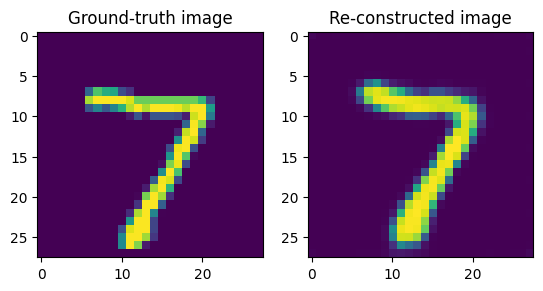

In [11]:
idx = 0
example = val_data[idx]

gt_img = np.asarray(example* 255)[0, :, :]

input_img = example.to(device).unsqueeze(0)
o, st_loss = model(input_img)
o = o.detach().cpu()
pred_img = np.asarray(o * 255)[0, 0, :, :]

f, axarr = plt.subplots(1,2)
axarr[0].imshow(gt_img)
axarr[0].set_title("Ground-truth image")
axarr[1].imshow(pred_img)
axarr[1].set_title("Re-constructed image")

plt.show()

In [ ]:
class FrechetInceptionDistance:
    """
    Computes the Fréchet Inception Distance. 

    It is defined as:
        d^2 = ||mu_r - mu_g||^2 + TR(C_r + C_g - 2*sqrt(C_r*C_g))

    where the subscription _r indicates real and _g generated.
    """
    def __init__(self, vq_vae_model):
        self._load_feature_extraction()
        self.vq_vae_model = vq_vae_model

    def _load_feature_extraction(self):
        feature_model = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        feature_model = feature_model.eval()
        feature_model = feature_model.to(device)

        # Layer names can be found with:
        #  train_nodes, eval_nodes = torchvision.models.feature_extraction.get_graph_node_names(inception_v3())
        feature_model = create_feature_extractor(feature_model, return_nodes={"avgpool": "output"})
        self.feature_model = feature_model

        inception_transforms = Inception_V3_Weights.IMAGENET1K_V1.transforms()
        inception_transforms = inception_transforms.to(device)
        self.inception_transforms = inception_transforms

    def get_feature_vector(self, imgs):
        imgs = imgs.repeat((1, 3, 1, 1))
        imgs = imgs * 255
        t_imgs = self.inception_transforms(imgs)
        t_imgs = t_imgs

        a = self.feature_model(t_imgs)

        o = a["output"].squeeze(-1).squeeze(-1).cpu().numpy()
        return o

    def __call__(self, val_data):
        val_loader = DataLoader(val_data, batch_size=256, shuffle=False, pin_memory=True, num_workers=4)

        real_output, generated_output = [], []
        with torch.no_grad():
            for imgs in val_loader:
                imgs = imgs.to(device)

                real_feature_vector = self.get_feature_vector(imgs)
                real_output.append(real_feature_vector)

                o, _ = self.vq_vae_model(imgs)
                generated_feature_vector = self.get_feature_vector(o)
                generated_output.append(generated_feature_vector)

        act_real = np.concatenate(real_output)
        mu_real = np.mean(act_real, axis=0)
        sigma_real = np.cov(np.transpose(act_real))

        act_generated = np.concatenate(generated_output)
        mu_generated = np.mean(act_generated, axis=0)
        sigma_generated = np.cov(np.transpose(act_generated))

        diff = mu_real - mu_generated
        d = diff.dot(diff) + np.trace(sigma_real) + np.trace(sigma_generated) - 2 * np.trace(linalg.sqrtm(sigma_real.dot(sigma_generated)))
        return d

In [13]:
distance_instance = FrechetInceptionDistance(model)
fi_distance = distance_instance(val_data)
print(fi_distance)

/home/erik/code/git/ml_playground/computer_vision/generative_models/.venv/lib/python3.12/site-packages/torchvision/models/feature_extraction.py:175: UserWarning: NOTE: The nodes obtained by tracing the model in eval mode are a subsequence of those obtained in train mode. When choosing nodes for feature extraction, you may need to specify output nodes for train and eval mode separately.
  warnings.warn(msg + suggestion_msg)


5256.933778028993
